In [1]:
import copy
import curvefit
import pandas as pd
import pickle
import datetime
import numpy as np
from curvefit.model_generators import ModelPipeline, BasicModel
from curvefit.functions import expit, log_erf, identity, exponential
from curvefit.pv import PVModel
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import generate_data

In [3]:
confirmed_us = pd.read_csv(generate_data.base + generate_data.confirmed + 'US.csv')

In [4]:
confirmed_us

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,51,55,56,58,69,77,82,84,93,112
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,0,0,0,0,2,6,6,6,6,6
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,79,100,127,174,239,286,316,316,452,475
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,19,22,0,0,30,30,30,37,40,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3248,84090053,US,USA,840,90053.0,Unassigned,Washington,US,0.0000,0.0000,...,67,0,125,274,274,303,344,501,483,533
3249,84090054,US,USA,840,90054.0,Unassigned,West Virginia,US,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0
3250,84090055,US,USA,840,90055.0,Unassigned,Wisconsin,US,0.0000,0.0000,...,61,0,0,0,0,0,0,0,0,0
3251,84090056,US,USA,840,90056.0,Unassigned,Wyoming,US,0.0000,0.0000,...,0,0,0,0,0,0,0,0,0,0


In [10]:
confirmed_us.columns

Index(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State',
       'Country_Region', 'Lat', 'Long_', 'Combined_Key', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20',
       '4/2/20', '4/3/20', '4

In [6]:
us_states = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')

In [8]:
us_counties = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')

In [7]:
us_states

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0
...,...,...,...,...,...
1824,2020-04-04,Virginia,51,2407,52
1825,2020-04-04,Washington,53,7498,318
1826,2020-04-04,West Virginia,54,282,2
1827,2020-04-04,Wisconsin,55,2112,60


In [2]:
def return_se_as_f_of_t(t):
    return np.random.normal(scale=0.1)

In [3]:
dataset = pd.read_csv('dataset_for_CurveFit_JP.csv')
dataset = dataset[(dataset["State/UnionTerritory"] == "Japan") | (dataset["State/UnionTerritory"] == "Hubei")]
dataset = dataset.reset_index(drop=True)
dataset = dataset.sort_values(by=["DateI"])
dataset["SE"] = np.random.normal(scale=0.1, size=dataset.shape[0])
print(dataset["State/UnionTerritory"])

0     Japan
75    Hubei
76    Hubei
1     Japan
2     Japan
      ...  
70    Japan
71    Japan
72    Japan
73    Japan
74    Japan
Name: State/UnionTerritory, Length: 139, dtype: object


In [4]:
model = BasicModel(
    all_data=dataset,
    col_t="DateI",
    col_obs="Confirmed",
    col_group="State/UnionTerritory",
    col_obs_compare="Confirmed",
    all_cov_names=[
        "DaysCovariate",
        "DaysCovariate",
        "DaysCovariate",
    ],
    fun=log_erf,
    predict_space=log_erf,
    fit_dict={'fe_init': [1, 60, 0.05]},
    basic_model_dict={
        'col_obs_se': "SE",
        'col_covs': [
            ["DaysCovariate"],
            ["DaysCovariate"],
            ["DaysCovariate"],
        ],
        'param_names': ['alphalink', 'betalink', 'gammalink'],
        'link_fun': [exponential, identity, exponential],
        'var_link_fun': [exponential, identity, exponential],
    },
    obs_se_func=return_se_as_f_of_t,
)

In [5]:
print("Model pipeline setting up...")
model.setup_pipeline()
print("Model setup. Running fit...")
model.fit(dataset)
print("Model fitted")

Model pipeline setting up...
Model setup. Running fit...
Model fitted. Saving model...


/srv/conda/envs/notebook/lib/python3.7/site-packages/curvefit/functions.py:12: RuntimeWarning: overflow encountered in exp
  return np.exp(t+0.000000001)
/srv/conda/envs/notebook/lib/python3.7/site-packages/curvefit/model.py:175: RuntimeWarning: invalid value encountered in multiply
  for i, cov in enumerate(covs)
/srv/conda/envs/notebook/lib/python3.7/site-packages/curvefit/functions.py:48: RuntimeWarning: invalid value encountered in multiply
  return 0.5*params[2]*(special.erf(params[0]*(t - params[1])) + 1.0)


In [6]:
print("Saving model...")
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved.")

Model saved.


In [7]:
model.run(
    n_draws=180,
    prediction_times=np.linspace(0, 180, num=180),
    cv_threshold=0.001,
    smoothed_radius=[4,4],
    exclude_groups=["Hubei"],
    exclude_below=20,
)

Running PV for Hubei
Running PV for Japand time 63


/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


ValueError: x and y must have same first dimension, but have shapes (20,) and (180,)

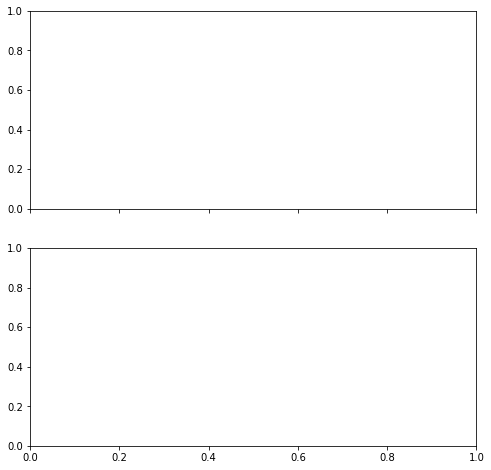

In [8]:
# model.plot_draws(
#     np.linspace(50, 70, num=20),
#     sharex=True,
#     sharey=False,
# )

In [10]:
predictions_Japan = np.exp(model.mean_predictions["Japan"])
predictions_Japan

array([0.5       , 0.92250345, 0.99777404, 0.99999007, 0.99999999,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

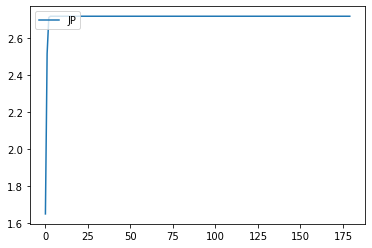

In [11]:
plt.plot(np.exp(predictions_Japan), label="JP")
plt.legend(loc="upper left")